# 第8章 イベントスタディ

In [1]:
ENV["LINES"] = 10
ENV["COLUMNS"] = 1000

1000

In [110]:
using DataFrames, DataFramesMeta, CSV, Dates, CategoricalArrays, GLM, Statistics, Gadfly, Distributions

In [36]:
#ch08_01
return_data_df = CSV.File("../../data/ch08_return_data.csv") |> DataFrame
market_return_data_df = CSV.File("../../data/ch08_market_return_data.csv") |> DataFrame
event_data_df = CSV.File("../../data/ch08_event_data.csv") |> DataFrame

println(first(return_data_df, 10))
println(first(market_return_data_df, 10))
println(first(event_data_df, 10))

10×3 DataFrame
 Row │ firm_ID  date        R           
     │ Int64    Date        Float64     
─────┼──────────────────────────────────
   1 │       1  2016-01-04  -0.0124486
   2 │       1  2016-01-05  -0.00918866
   3 │       1  2016-01-06   0.0320967
   4 │       1  2016-01-07  -0.0292583
   5 │       1  2016-01-08  -0.0239518
   6 │       1  2016-01-12   0.0152977
   7 │       1  2016-01-13   0.00787034
   8 │       1  2016-01-14  -0.0129339
   9 │       1  2016-01-15  -0.0119428
  10 │       1  2016-01-18  -0.0137229
10×2 DataFrame
 Row │ date        R_M         
     │ Date        Float64     
─────┼─────────────────────────
   1 │ 2016-01-04  -0.00435558
   2 │ 2016-01-05  -0.0066622
   3 │ 2016-01-06   0.0216314
   4 │ 2016-01-07  -0.0259588
   5 │ 2016-01-08  -0.0134088
   6 │ 2016-01-12   0.0056506
   7 │ 2016-01-13   0.00600699
   8 │ 2016-01-14  -0.00406643
   9 │ 2016-01-15  -0.0014726
  10 │ 2016-01-18  -0.00217638
10×5 DataFrame
 Row │ firm_ID  event_date  realized_ear

In [37]:
#ch08_02
event_data_df = @chain event_data_df begin
    @transform(:event_ID = 1:size(event_data_df)[1])
    @rtransform begin
        :forcast_innovation = (:earnings_forecast - :realized_earnings) / :lagged_ME
        :year = Dates.Year(:event_date).value
    end
    groupby(:year)
    @transform(:event_strength = cut(:forcast_innovation, 5, labels=1:5))
end

,firm_ID,event_date,realized_earnings,earnings_forecast,lagged_ME,event_ID,forcast_innovation,year,event_strength
,Int64,Date,Float64,Float64,Float64,Int64,Float64,Int64,Cat…
1,1,2017-05-08,421.79,500.38,8285.87,1,0.00948482,2017,5
2,2,2017-08-28,131.49,144.13,1551.31,2,0.00814795,2017,5
3,3,2017-10-17,459.3,463.03,3154.17,3,0.00118256,2017,1
4,4,2017-10-17,976.94,1298.48,19323.2,4,0.0166401,2017,5
5,5,2017-02-09,706.28,779.63,9351.8,5,0.00784341,2017,5
6,6,2017-05-23,530.62,544.65,7558.49,6,0.00185619,2017,1
7,7,2017-05-16,613.26,717.0,11947.4,7,0.00868305,2017,5
8,8,2017-03-08,142.95,157.86,2215.57,8,0.00672965,2017,4
9,9,2017-10-10,802.61,792.09,13913.7,9,-0.000756088,2017,1


In [46]:
#ch08_03
N_DAYS = nrow(market_return_data_df)
N_FIRMS = length(unique(return_data_df.firm_ID))
N_EVENTS = nrow(event_data_df)

N1 = 100
N2 = 30
N3 = 30


30

In [39]:
#ch08_04
@transform!(market_return_data_df, :date_ID = 1:N_DAYS)
data_ID_table_df = @select(market_return_data_df, :date, :date_ID)
return_data_df = innerjoin(return_data_df, data_ID_table_df, on = [:date])
event_data_df = @chain event_data_df begin
    leftjoin(data_ID_table_df, on = :event_date => :date)
    @select(:event_ID, :date_ID, :firm_ID, :event_strength)
    rename(:date_ID => :event_date_ID)
end

,event_ID,event_date_ID,firm_ID,event_strength
,Int64,Int64?,Int64,Cat…
1,1,329,1,5
2,2,407,2,5
3,3,441,3,1
4,4,441,4,5
5,5,271,5,5
6,6,340,6,1
7,7,335,7,5
8,8,290,8,4
9,9,436,9,1


In [42]:
#ch08_05
return_data_df = @chain return_data_df begin
    @select($(Not(:date)))
    innerjoin(market_return_data_df, on = :date_ID)
end

,firm_ID,R,date_ID,date,R_M
,Int64,Float64,Int64,Date,Float64
1,1,-0.0124486,1,2016-01-04,-0.00435558
2,1,-0.00918866,2,2016-01-05,-0.0066622
3,1,0.0320967,3,2016-01-06,0.0216314
4,1,-0.0292583,4,2016-01-07,-0.0259588
5,1,-0.0239518,5,2016-01-08,-0.0134088
6,1,0.0152977,6,2016-01-12,0.0056506
7,1,0.00787034,7,2016-01-13,0.00600699
8,1,-0.0129339,8,2016-01-14,-0.00406643
9,1,-0.0119428,9,2016-01-15,-0.0014726


In [53]:
#ch08_06
full_sample_data_df = DataFrame(
    :event_ID => sort(repeat(1:N_EVENTS, N1 + N2 + N3 + 1)),
    :relative_days => repeat(-(N1 + N2):N3, N_EVENTS)
)

,event_ID,relative_days
,Int64,Int64
1,1,-130
2,1,-129
3,1,-128
4,1,-127
5,1,-126
6,1,-125
7,1,-124
8,1,-123
9,1,-122


In [57]:
#ch08_07
full_sample_data_df = @chain full_sample_data_df begin
    innerjoin(event_data_df, on = :event_ID)
    @rtransform(:date_ID = :event_date_ID + :relative_days + 1)
    leftjoin(return_data_df, on = [:firm_ID, :date_ID])
    @select(:event_ID, :event_strength, :relative_days, :R, :R_M)
end

,event_ID,event_strength,relative_days,R,R_M
,Int64,Cat…,Int64,Float64?,Float64?
1,1,5,-130,-0.0114803,-0.00196745
2,1,5,-129,-0.00647647,-0.0073374
3,1,5,-128,-0.0168033,-0.0099033
4,1,5,-127,-0.00536318,-0.00625963
5,1,5,-126,-0.0313299,-0.012872
6,1,5,-125,-0.00848441,-0.00405933
7,1,5,-124,0.00853949,0.00608298
8,1,5,-123,-0.0118673,-0.0106627
9,1,5,-122,-0.00354088,0.00273823


In [74]:
#ch08_08
estimation_window_data_df = @chain full_sample_data_df begin
    @rsubset(:relative_days < -N2)
end

market_model_results_df = DataFrame()
for i in 1:N_EVENTS
    tmp_df = @rsubset(estimation_window_data_df, :event_ID == i)
    mdl = lm(@formula(R ~ R_M), tmp_df)
    tmp_result_df = @chain DataFrame(coeftable(mdl)) begin
        @transform(:event_ID = i)
        @select(:event_ID, $(Not(:event_ID)))
        @rtransform(:sigma_AR = GLM.dispersion(mdl.model))
    end
    append!(market_model_results_df, tmp_result_df)
end

In [73]:
result_df

,event_ID,Name,Coef.,Std. Error,t,Pr(>|t|),Lower 95%,Upper 95%,sigma_AR
,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,(Intercept),-0.0018169,0.000740397,-2.45396,0.015894,-0.0032862,-0.000347612,0.00737972
2,1,R_M,1.14012,0.0673742,16.9222,7.68205e-31,1.00642,1.27382,0.00737972
3,2,(Intercept),0.00119668,0.000759518,1.57558,0.118345,-0.000310557,0.00270392,0.00753665
4,2,R_M,0.303635,0.0755837,4.01721,0.00011554,0.153642,0.453629,0.00753665
5,3,(Intercept),0.000241587,0.000830632,0.290847,0.771783,-0.00140677,0.00188995,0.00828232
6,3,R_M,1.22318,0.0803453,15.224,1.43768e-27,1.06374,1.38262,0.00828232
7,4,(Intercept),-0.00109937,0.00078319,-1.40371,0.163567,-0.00265359,0.000454846,0.00780928
8,4,R_M,0.886377,0.0757564,11.7004,2.60839e-20,0.736041,1.03671,0.00780928
9,5,(Intercept),-0.000453806,0.000839719,-0.540426,0.59013,-0.0021202,0.00121259,0.00839619


In [85]:
#ch08_09
full_sample_data_df = @chain market_model_results_df begin
    rename(:Name => :term)
    rename("Coef." => :estimate)
    unstack([:event_ID, :sigma_AR], :term, :estimate)
    rename("(Intercept)" => :alpha)
    rename(:R_M => :beta)
    innerjoin(full_sample_data_df, on = :event_ID)
    @select(:event_ID, :event_strength, :relative_days, :R, :R_M, :alpha, :beta, :sigma_AR)
end

,event_ID,event_strength,relative_days,R,R_M,alpha,beta,sigma_AR
,Int64,Cat…,Int64,Float64?,Float64?,Float64?,Float64?,Float64
1,1,5,-130,-0.0114803,-0.00196745,-0.0018169,1.14012,0.00737972
2,1,5,-129,-0.00647647,-0.0073374,-0.0018169,1.14012,0.00737972
3,1,5,-128,-0.0168033,-0.0099033,-0.0018169,1.14012,0.00737972
4,1,5,-127,-0.00536318,-0.00625963,-0.0018169,1.14012,0.00737972
5,1,5,-126,-0.0313299,-0.012872,-0.0018169,1.14012,0.00737972
6,1,5,-125,-0.00848441,-0.00405933,-0.0018169,1.14012,0.00737972
7,1,5,-124,0.00853949,0.00608298,-0.0018169,1.14012,0.00737972
8,1,5,-123,-0.0118673,-0.0106627,-0.0018169,1.14012,0.00737972
9,1,5,-122,-0.00354088,0.00273823,-0.0018169,1.14012,0.00737972


In [93]:
#ch08_10
event_window_data_df = @chain full_sample_data_df begin
    @rsubset(:relative_days >= -N2)
    @rtransform begin
        :R_normal = :alpha + :beta * :R_M
    end
    @rtransform begin
        :AR = :R - :R_normal
    end
    groupby(:event_ID)
    @transform(:CAR = cumsum(:AR))
end

,event_ID,event_strength,relative_days,R,R_M,alpha,beta,sigma_AR,R_normal,AR,CAR
,Int64,Cat…,Int64,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64
1,1,5,-30,0.0194146,0.00470496,-0.0018169,1.14012,0.00737972,0.00354732,0.0158672,0.0158672
2,1,5,-29,0.00654325,-0.00198562,-0.0018169,1.14012,0.00737972,-0.00408075,0.010624,0.0264912
3,1,5,-28,0.00235643,-0.00229335,-0.0018169,1.14012,0.00737972,-0.0044316,0.00678803,0.0332793
4,1,5,-27,-0.0156699,0.00223688,-0.0018169,1.14012,0.00737972,0.000733406,-0.0164033,0.016876
5,1,5,-26,0.018545,0.014951,-0.0018169,1.14012,0.00737972,0.015229,0.00331601,0.020192
6,1,5,-25,0.0150776,0.0180968,-0.0018169,1.14012,0.00737972,0.0188157,-0.00373808,0.0164539
7,1,5,-24,0.00724919,0.00444786,-0.0018169,1.14012,0.00737972,0.0032542,0.00399499,0.0204489
8,1,5,-23,0.011517,0.00349044,-0.0018169,1.14012,0.00737972,0.00216262,0.00935436,0.0298033
9,1,5,-22,-0.0189529,-0.00645015,-0.0018169,1.14012,0.00737972,-0.00917086,-0.00978205,0.0200212


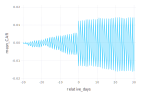

In [100]:
#ch08_11
@chain event_window_data_df begin
    groupby([:relative_days, :event_strength])
    @combine(:mean_CAR = mean(:CAR))
    plot(x = :relative_days, y = :mean_CAR, Geom.line)
end

In [106]:
output_table_df = @chain event_window_data_df begin
    @rsubset(:event_strength == 5)
    groupby(:relative_days)
    @combine begin
        :mean_AR = mean(:AR)
        :mean_CAR = mean(:CAR)
        :sigma_mean_AR = sqrt(sum(:sigma_AR .^ 2)) / length(:sigma_AR)
    end
end

,relative_days,mean_AR,mean_CAR,sigma_mean_AR
,Int64,Float64,Float64,Float64
1,-30,-0.000332789,-0.000332789,0.000284734
2,-29,0.000346005,1.32162e-5,0.000284734
3,-28,-3.04693e-5,-1.7253e-5,0.000284734
4,-27,0.000242308,0.000225055,0.000284734
5,-26,0.000420184,0.00064524,0.000284734
6,-25,0.000208185,0.000853424,0.000284734
7,-24,0.000533655,0.00138708,0.000284734
8,-23,-2.84598e-5,0.00135862,0.000284734
9,-22,-0.00014238,0.00121624,0.000284734


In [114]:
#ch08_13
@chain output_table_df begin
    @rtransform begin
        :t_value = :mean_AR / :sigma_mean_AR
    end
    @rtransform begin
        :p_value = (1 - cdf(Normal(), abs(:t_value))) * 2
    end
    @transform begin
        significance = cut(:p_value, [0, 0.01, 0.05, 0.1, 1], labels=["***", "**", "*", ""])
    end
    @select(:relative_days, :mean_AR, :t_value, :p_value, :significance, :mean_CAR)
end

,relative_days,mean_AR,t_value,p_value,significance,mean_CAR
,Int64,Float64,Float64,Float64,Cat…,Float64
1,-30,-0.000332789,-1.16877,0.242495,,-0.000332789
2,-29,0.000346005,1.21519,0.224294,,1.32162e-5
3,-28,-3.04693e-5,-0.10701,0.914781,,-1.7253e-5
4,-27,0.000242308,0.850999,0.39477,,0.000225055
5,-26,0.000420184,1.47571,0.140022,,0.00064524
6,-25,0.000208185,0.731156,0.464684,,0.000853424
7,-24,0.000533655,1.87423,0.0608993,*,0.00138708
8,-23,-2.84598e-5,-0.0999523,0.920382,,0.00135862
9,-22,-0.00014238,-0.500047,0.617042,,0.00121624
